In [38]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting

import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size


In [39]:
df = pd.read_csv('../data/clean_train.csv')

In [40]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [41]:
df =  df.drop(['Unnamed: 0', 'pickup_date'], 1)

In [42]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month

# Clustering visualizations

- Make a list of all of the longitudes and latitudes for both pick up and drop off coordinates
- Using MiniBatchKmeans (faster) fit to 15 clusters using the new list of all the geolocation coordinates
- Predict to each of the pickup and dropoff long/lat coords, labeling the clusters, using the model described above

In [43]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

In [44]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [45]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=15, batch_size=10000, random_state = 42).fit(loc_df) #fit to 15 clusters using all coordinates
loc_df['label'] = kmeans.labels_

In [46]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])

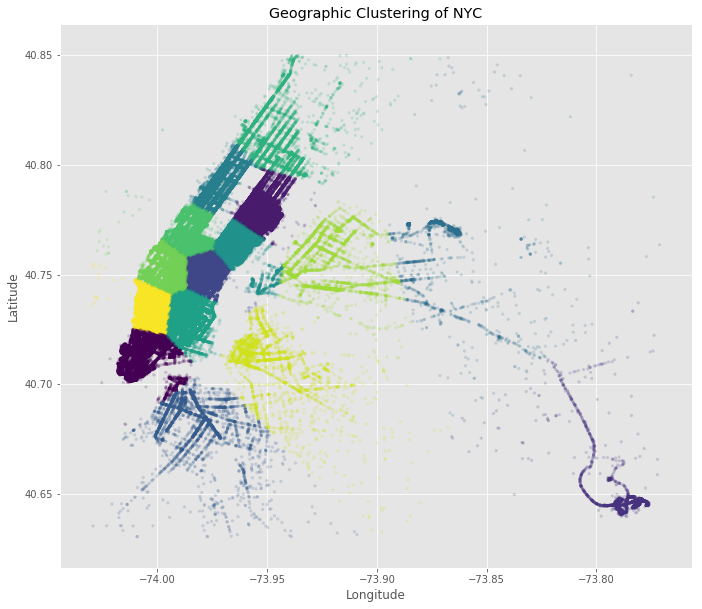

In [47]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df.pickup_longitude.values[:500000], df.pickup_latitude.values[:500000], s=10, lw=0,
           c=df.pickup_cluster[:500000].values, alpha=0.2)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Geographic Clustering of NYC')
plt.show()

**Plot of NYC taxi data Clustered by Geographic Location**

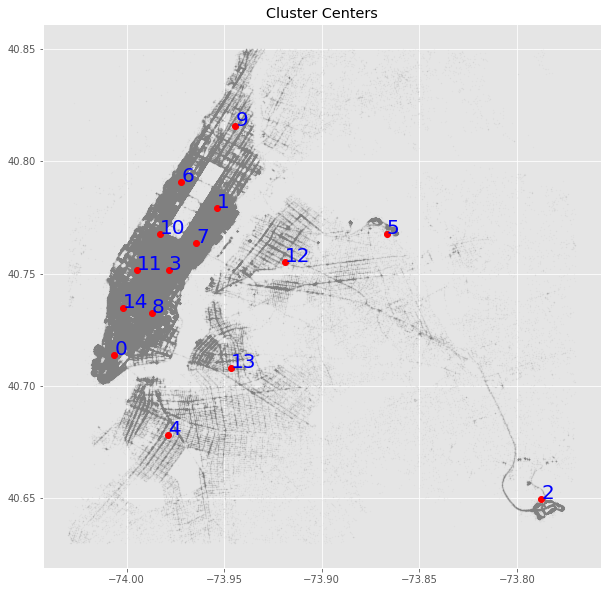

In [48]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

**Cluster Centeres Labeled**

In [49]:
table = df.groupby('pickup_cluster')['dropoff_cluster'].value_counts()
table = pd.DataFrame(table)

In [50]:
table2 = table.unstack(level=1)
table2

dropoff_cluster                                                \
dropoff_cluster              0      1     2      3     4     5      6      7    
pickup_cluster                                                                  
0                         21673   2324   967  10152  4992  1731   1311   3698   
1                          2734  39015   830  13219   581  1876  12346  27763   
2                          1739   1303  3232   3593  2678  2075   1121   1460   
3                         11028  14545  2615  35536  2551  5348   4925  24887   
4                          1568    142   156    546  6743   253     80    314   
5                          2506   2052   809   6268  2312  3377   1559   2552   
6                          1093  12460   586   4115   283  1058  23672   6665   
7                          4675  32306  1017  26834  1207  2472   7415  33849   
8                         16839   6924  1204  27150  5685  2097   2616  10270   
9                           181   2714   152    505    78   418   3094    704   
10                         6164  13321  2000  20331  1375  3994  19659  17754   
11                        11580   7292  1496  31734  2757  2639   5665  11596   
12                          171    571   202    702   124  1304    125   1215   
13                          407    100   107    266  1521   177     59    195   
14                        16110   3486   692  13661  3514  1145   2655   4985   

                                                               
dropoff_cluster     8     9      10     11    12    13     14  
pickup_cluster                                                 
0                14105   895   5359  10220   690  3376  13808  
1                 5035  7105  11155   5750  1123   458   2351  
2                 1898   875   3210   2281  1026  2470   1200  
3                26640  2405  19436  27978  2582  2077  12537  
4                  766    85    223    393   141  2094    470  
5                 2296  1297   4481   2896  2248  1812   1312  
6                 1672  8799  16089   4258   329   184   1564  
7                10164  2965  15912  10706  2902  1207   4837  
8                39877  2301   7542  19367  2049  7269  22480  
9                  329  8497   1052    611   114    72    222  
10                7855  5180  32895  23968  2197  1126   8090  
11               20959  3435  26432  33337  1781  2196  19650  
12                 307   225    282    318  5589   341    131  
13                 789    80    111    181   368  5672    213  
14               23366  1820   9541  21628  1023  3078  22205

Text(0.5, 1.0, 'Heatmap version - Value Count of Rides')

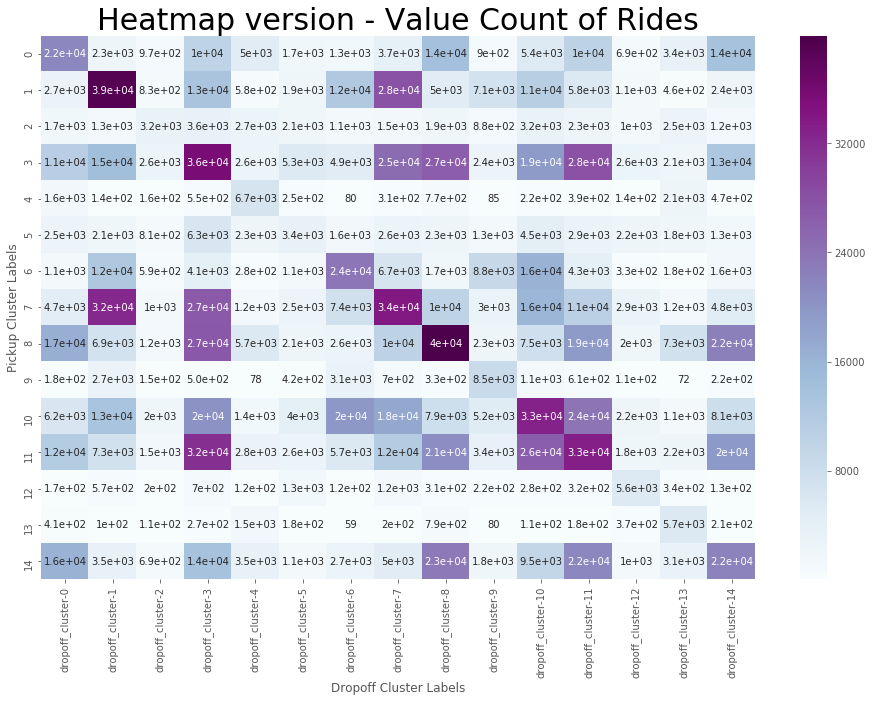

In [51]:
sns.heatmap(table2, annot = True,  cmap="BuPu").set(xlabel= 'Dropoff Cluster Labels', ylabel = 'Pickup Cluster Labels')
plt.title('Heatmap version - Value Count of Rides', fontsize = 30)

The table above can be interpreted as following: the row labels indicate the pickup_cluster labels. the column labels indicate the corresponding dropoff_cluster label. The values are the value counts of the taxi ride intances that the pickup_cluster label resulted in the corresponding dropoff_cluster.

For example, 21673 rides were picked up at cluster 0 and dropped off at cluster 0 (top left corner of the table). Then 2734 rides were picked up at cluster 1 and dropped off at cluster 0 (the cell immediately below the top right corner of the table). The table follows such format etc. 

The heatmap version of the table is a more visually attractive way of seeing which clusters are frequently traversed between via taxis in NYC. Obviously, there is alot of taxi traffic between solely within cluster 8, amounting to more than 50000 rides. The more "purple" the cell, the more rides there are between the two corresponding pickup and dropoff clusters. 

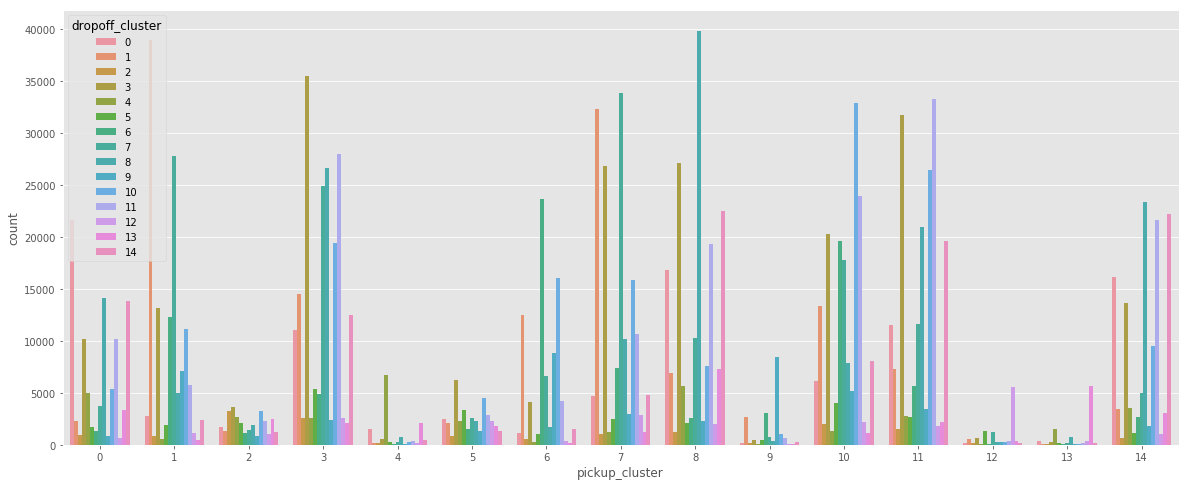

In [52]:
plt.figure(figsize=(20,8))
sns.countplot(x='pickup_cluster', hue='dropoff_cluster', data=df)

As a different way of visualizing the heatmap, the above countplot shows the same visual information as the table aforementioned table. Alot of the times, we start seeing rides that pick up and drop off within the same cluster, suggesting that taxi rides are usually short rides (which we know from seeing the histogram of average taxi ride distances). 

In general, not many people seem to be getting picked up by taxis in clusters 2,4,5,9,12, and 13. These clusters all correspond to the geographic locations outside of the island of Manhattan. It information also matches up with the density of the scatter plots shown on the cluster labeled plots, as there are significantly less densities of scatter points outside of Manhattan.

[Text(0, 0.5, 'average manhattan distance traveled per ride (km)'),
 Text(0.5, 0, 'pickup_cluster')]

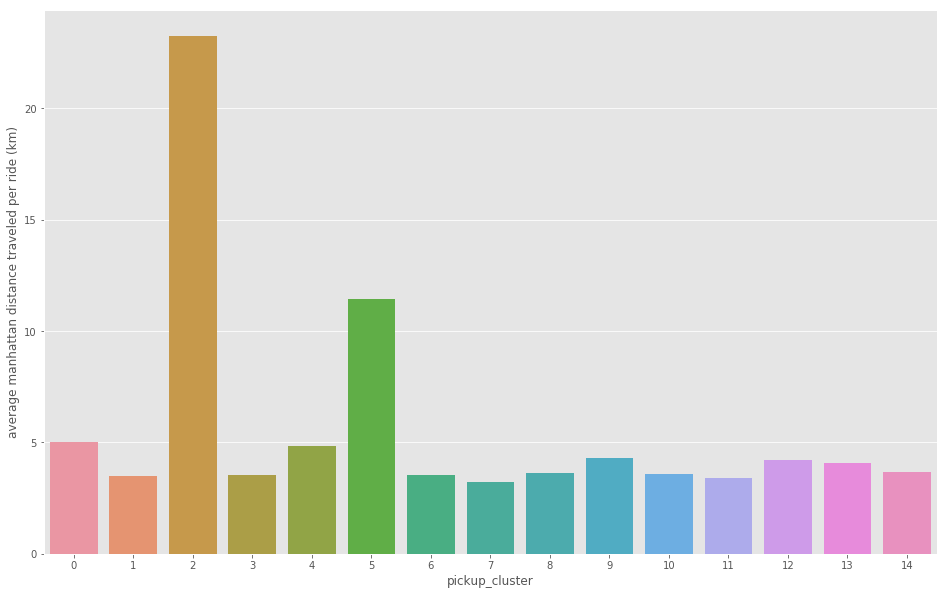

In [53]:
clust_dist = df.groupby('pickup_cluster')['distance_dummy_manhattan'].mean()
sns.barplot(clust_dist.index, clust_dist.values).set(xlabel = 'pickup_cluster', ylabel = 'average manhattan distance traveled per ride (km)')

Accordingly, we can see that clusters 2 and 5 (signifying JFK and La Guardia airports, respectively) have the highest average distance traveled per ride. This is not a surprise, as these are the destinations farthest away from Manhattan proper.

[Text(0, 0.5, 'Ride Count'), Text(0.5, 0, 'pickup_cluster')]

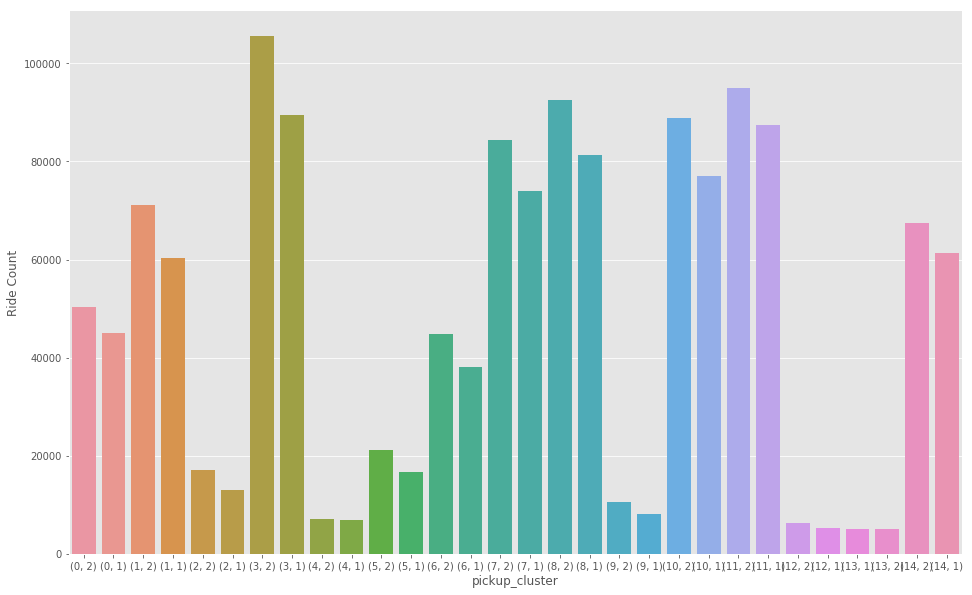

In [54]:
clust_vendor = df.groupby('pickup_cluster')['vendor_id'].value_counts()
sns.barplot(clust_vendor.index, clust_vendor.values).set(xlabel = 'pickup_cluster', ylabel = 'Ride Count')

When grouping by pickup cluster and vendors, we see that vendor 2 always seems to pick up more rides, but on average the proportion of rides that they service remain about the same thhroughout the clusters, leading us to believe that taxi drivers do not favor a certain pickup location based on vendor id. 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436572 entries, 0 to 1436571
Data columns (total 25 columns):
id                          1436572 non-null object
vendor_id                   1436572 non-null int64
pickup_datetime             1436572 non-null datetime64[ns]
dropoff_datetime            1436572 non-null datetime64[ns]
passenger_count             1436572 non-null int64
pickup_longitude            1436572 non-null float64
pickup_latitude             1436572 non-null float64
dropoff_longitude           1436572 non-null float64
dropoff_latitude            1436572 non-null float64
store_and_fwd_flag          1436572 non-null int64
trip_duration               1436572 non-null int64
date                        1436572 non-null datetime64[ns]
minimum temperature         1436572 non-null int64
precipitation               1436572 non-null float64
snow fall                   1436572 non-null float64
snow depth                  1436572 non-null float64
log_trip_duration           1

Now, let's overwrite the clean_data.csv with the current dataframe, so that we have the cluster labels as a predictor variable once we go on to build a predictive modelling scheme for trip duration. 

In [56]:
df.to_csv('../data/clean_train.csv')